# Import libraries

In [45]:
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, AutoModelForCausalLM, Trainer, TrainingArguments, get_cosine_schedule_with_warmup
from datasets import load_dataset
import pathlib
import torch
import pandas
from collections import Counter
import re

# Load the data

We'll use the Million Song Dataset from Kaggle as our training data. We can use the Datasets class from Huggingface to quickly load the data, then we'll utilize visualization tools to see artists in a subset of the data.

Using custom data configuration default-a497b4a7fe246336
Found cached dataset csv (/Users/renaef/.cache/huggingface/datasets/csv/default-a497b4a7fe246336/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

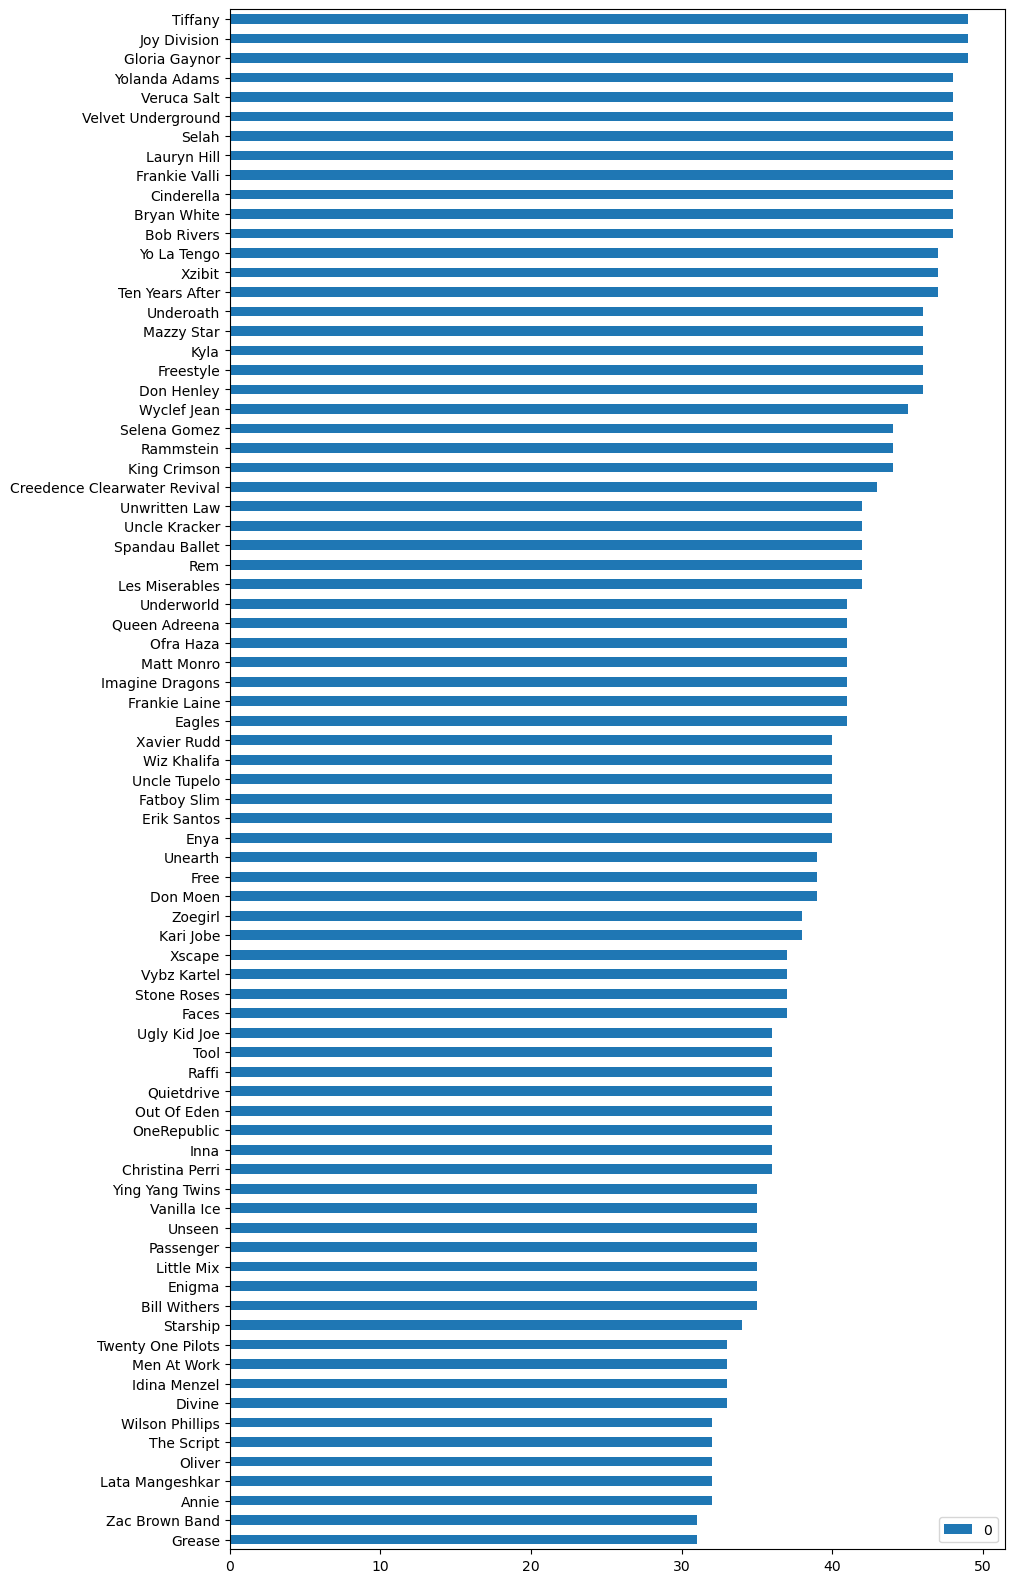

In [14]:
# Load the data and discard the dictionary wrapper.
dataset = load_dataset("csv", data_files="./data/spotify_millsongdata.csv")['train']

# Count how many times each artist appears in the data.
artist_counts = Counter(dataset['artist'])

# Choose artists with fewer than 50 and more than 25 songs.
filtered_artists = dict(filter(lambda elem: elem[1] < 50 and elem[1] > 30, artist_counts.items()))

# Create a list of artists sorted by the number of songs they have in the data.
sorted_artists = dict(sorted(filtered_artists.items(), key=lambda item: item[1]))

# Plot the sorted list of artists.
df = pandas.DataFrame.from_dict(sorted_artists, orient='index')
df.plot(kind='barh',figsize=(10, 20))

We will select one artist from our data set, remove any irrelevant information, and divide the data into training and test sets.

In [15]:
# Choose one artist from this subset because it will be faster to fine-tune the model on fewer data (for this example).
filtered_dataset = dataset.filter(lambda example: 'gloria gaynor' in example["artist"].lower())

# Remove uneeded columns and retain only the text column that holds the song lyrics.
filtered_dataset = filtered_dataset.remove_columns(["artist","song","link"])

# Split the data into test and training datasets (0.20 of the shuffled dataset will be reserved to test the model).
dataset_dict = filtered_dataset.train_test_split(test_size=0.20, shuffle=True, seed=123)

print(dataset_dict)

Loading cached processed dataset at /Users/renaef/.cache/huggingface/datasets/csv/default-a497b4a7fe246336/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-15fa78072ce9e22d.arrow
Loading cached split indices for dataset at /Users/renaef/.cache/huggingface/datasets/csv/default-a497b4a7fe246336/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-c98574f63defb9bc.arrow and /Users/renaef/.cache/huggingface/datasets/csv/default-a497b4a7fe246336/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-a87123be87c8cbb1.arrow


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 39
    })
    test: Dataset({
        features: ['text'],
        num_rows: 10
    })
})


# Tokenize the data

We need to convert our text into sequences of numbers before we can put it into GPT-2. To do this, we can use a tokenizer that is specifically designed for GPT-2 to create these sequences.

In [16]:
# Create the GPT-2 text tokenizer. This will convert text into a numerical representation for the training process.
tokenizer = AutoTokenizer.from_pretrained('gpt2')

# Define a function that we'll use in the map function to tokenze data in the 'text' column.
def tokenize_function(examples):
    return tokenizer(examples["text"])

# Apply tokenizer on each song text in the dataset & remove the raw text column.
# It creates a dictionary with keys input_id and attention_mask, and each key references an array of arrays.
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True, remove_columns=["text"])

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /Users/renaef/.cache/huggingface/hub/models--gpt2/snapshots/f27b190eeac4c2302d24068eabf5e9d6044389ae/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
   

# Create batched datasets

To generate song sequences with GPT-2, we need to divide our data into sections of fewer than 1024 tokens. We could truncate the songs and use a DataCollator to pad any additional spaces, so that all input sequences have the same length. However, to preserve as much information as possible from the original data, we should manually concatenate the text and generate labels for the GPT-2 model.

In [17]:
# Get the maximum length, in number of tokens, for the inputs to the GPT-2 model.
block_size = tokenizer.model_max_length

# Define a function that we'll use in a map function to format the data for the GPT-2 model.
def group_texts(examples):

    # Concatenate all tokenized texts and masks.
    # For each key in the dictionary, use sum(examples[key], []) to concatenate all lists.
    concatenated_examples = {key: sum(examples[key], []) for key in examples.keys()}

    # Get the total length of the concatenated texts.
    total_length = len(concatenated_examples["input_ids"])

    # Calculate the max length by rounding down the total length to the nearest block size. 
    max_length = (total_length // block_size) * block_size

    # Create a dictionary of keys with values split into chunks of max length.
    result_dict = {
        # From i to range of max_length, by block_size, create a list of values from i to i + block_size.
        keys: [values[i : i + block_size] for i in range(0, max_length, block_size)] 

        # Perform this for every key in the dictionary.
        for keys, values in concatenated_examples.items()
    }

    # Create labels from copies of the input_ids. This is necessary for language modeling. Since these are shifted inside the model, we can set input_ids = labels.
    result_dict["labels"] = result_dict["input_ids"].copy()

    return result_dict

# Use the map function and the group_texts function to format the data.
lm_datasets = tokenized_datasets.map(group_texts, batched=True)

print(lm_datasets)

Loading cached processed dataset at /Users/renaef/.cache/huggingface/datasets/csv/default-a497b4a7fe246336/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-e0af6c01a44a3049.arrow
Loading cached processed dataset at /Users/renaef/.cache/huggingface/datasets/csv/default-a497b4a7fe246336/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-01d07af6ca0c096a.arrow


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 18
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4
    })
})


# Train the model

In [ ]:
# Select a pretrained GPT-2 model with a head that we can train.
model = AutoModelForCausalLM.from_pretrained('gpt2', cache_dir=pathlib.Path('cache').resolve())

# Define arguments such as learning rate, weight decay, number of training epochs, that affect how the model learns.
training_args = TrainingArguments(
    output_dir="output",
    overwrite_output_dir=True,
    evaluation_strategy = "epoch",
    do_eval=True,
    learning_rate=1.372e-4,
    weight_decay=0.05,
    lr_scheduler_type="cosine",
    num_train_epochs=9,
    save_total_limit=10,
    save_strategy='epoch',
    report_to=None,
    seed=123,
    load_best_model_at_end=True
)

# Create an instance of the training with our model, training arguments, and batched datasets.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"]
)

trainer.train()

# Test the model

In [23]:
evaluation = trainer.evaluate()
evaluation

***** Running Evaluation *****
  Num examples = 4
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.9597671031951904,
 'eval_runtime': 3.574,
 'eval_samples_per_second': 1.119,
 'eval_steps_per_second': 0.28,
 'epoch': 9.0}

In [83]:
start = "I am"
num_sequences =  5
min_length =  100
max_length =   150
temperature = 1
top_p = 0.90
top_k = 50
repetition_penalty =  1

# Tokenize the starting prompt with the GPT-2 tokenizer we created earlier.
tokenized_prompt = tokenizer(start, return_tensors="pt")

encoded_prompt = tokenized_prompt.input_ids.to(trainer.model.device)
attention_mask = tokenized_prompt.attention_mask.to(trainer.model.device)

# Create a series of predictions with out encoded prompt, attention mask, and other variables.
output_sequences = trainer.model.generate(
    input_ids=encoded_prompt,
    attention_mask=attention_mask,
    max_length=max_length,
    min_length=min_length,
    temperature=float(temperature),
    top_p=float(top_p),
    top_k=int(top_k),
    do_sample=True,
    repetition_penalty=repetition_penalty,
    num_return_sequences=num_sequences)

# Define a function that will decode the predictions and clean up the text for display purposes.
def post_process(output_sequences):
    generated_sequences = []
    predictions = []

    # Decode the prediction with the tokenizer.
    for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
        generated_sequence = generated_sequence.tolist()
        text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True, skip_special_tokens=True)
        generated_sequences.append(text.strip())

    # Loop over the decoded predections and use regular expression to clean up the data.
    for i, g in enumerate(generated_sequences):

        # Replace multiple newlines with a single one.
        res = re.sub(r'[\u000A-\u000D]+','\n', str(g))

        # Replace multiple spaces with a single one.
        res = re.sub(r'[\u0020\t]+',' ', res)

        # Remove all C0 controls other than newlines.
        res = re.sub(r'[\u0000-\u0009\u000E-\u001F\u007F]+','',res)

        # Remove non ASCII characters.
        res = re.sub(r'[^\x00-\x7F]','',res)

        predictions.append(res)
    
    return predictions

# Use the post_process function to display some predictions.
for s in post_process(output_sequences):
    print(s)
    print()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am really not a fan of your games."
In this case, she'd been playing with her brother, who was playing with his sister, so she was not so keen to get too excited.
"I think I might be too old for a game."
"But hey, hey, can't you please say my name? It's too much to ask."
Just like the girl you found, she was just sitting around your bed.
"I'm still awake. How can you just leave me so far behind?"
"I can keep waiting to see if I can make it all the way to the end."
This was so good that she didn't want to take it any

I am your servant, Master. Please do your best to fulfill my needs for you."
"Oh yes, yes, my love. I love you too much."
He then said goodbye, but he couldn't stop thinking of you.
"You will be my baby again. I'm gonna make it happen."
He had no other choice but to bring you to life. And love, I am just glad you were there to help."
I could feel him, as if someone just told me to keep it together.

I am not the man who has had his heart turned upside down."
"But you can

# Save the model

In [29]:
trainer.save_model("./model")

Saving model checkpoint to ./model
Configuration saved in ./model/config.json
Model weights saved in ./model/pytorch_model.bin


# Sources

- Chapter 7: Deep Learning for Text, Deep Learning in Python by François Chollet
- GPT-2, Accessed at: https://huggingface.co/gpt2
- Spotify Million Song Dataset, Accessed at: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
- OpenAPI GPT-2, Accessed at: https://huggingface.co/docs/transformers/main/en/model_doc/gpt2
- Fine-tune a pretrained model, Accessed at: https://huggingface.co/docs/transformers/training
- HuggingArtists - Train a model to generate lyrics, Accessed at: https://colab.research.google.com/github/AlekseyKorshuk/huggingartists/blob/master/huggingartists-demo.ipynb
- Datasets, Accessed at: https://huggingface.co/docs/datasets/index
- Fine-Tuning a Pretrained Model: Processing the data, Accessed at: https://huggingface.co/course/chapter3/2

```{bibliography}
```